In [21]:
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from torch.utils.data import DataLoader,Dataset


DAYS_FOR_TRAIN = 3
FEATURE_SIZE = 10
BATCH_SIZE = 32
TEST_SIZE = 0.3
DROPOUT_PROB = 0

with_sent = False

# selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30]
if with_sent:
    selected_ft = [1, 2, 3, 4, 5, 6, 7, 59, 28, 44, 21, 34, 35, 27, 17, 19, 16, 26, 69, 90, 45, 60, 20, 62, 38, 68, 30] # with sent
else:
    selected_ft = [1, 2, 3, 4, 5, 57, 26, 42, 19, 32, 33, 25, 15, 17, 14, 24, 67, 88, 43, 58, 18, 60, 36, 66, 28] 
    
selected_ft = selected_ft[:FEATURE_SIZE]



In [22]:
def my_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(extend_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


class StockDataset(Dataset):
    """stock market dataset"""
    
    def __init__(self, dataset, days_for_train=5, feature_size=5, scaled=True, scaler=None):
        self.days_for_train = days_for_train
        self.feature_size = feature_size
        self.ori_data = dataset

        self.data = self.ori_data.iloc[:, selected_ft].values.astype(np.float32)
#         print(self.data)
        if scaled:
            if scaler is None:
                self.scaler = MinMaxScaler()
                self.data = self.scaler.fit_transform(self.data).astype(np.float32)
            else:
                self.data = scaler.transform(self.data).astype(np.float32)
                self.scaler = scaler
        
        self.x = self.data
        self.y = self.data[:, 3]
        
        

    def __len__(self):
        return self.data.shape[0] - self.days_for_train

    
    def __getitem__(self, idx):
        x = self.x[idx:idx+self.days_for_train]
        y = np.zeros((1), dtype=np.float32)

        y[0] = self.y[idx+self.days_for_train]

        t_x = torch.from_numpy(x)
        t_y = torch.from_numpy(y)
        return t_x, t_y
    
    def get_scaler(self):
        return self.scaler


class BaseLSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

        self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)

    def forward(self, _x):
        out0 = self.fc0(_x)
        x, _ = self.lstm(out0)  # _x is input, size (seq_len, batch, input_size)
        s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        x = x.view(s*b, h)
        out1 = self.fc(x)
        out1 = out1.view(s, b)  # 把形状改回来
        out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
        out2 = self.fc2(out1)
        # print(out2.shape)
        # out2 = out2.view(b, -1)
        return out2
    

class LSTM_Regression(nn.Module):
    """
        使用LSTM进行回归
        
        参数：
        - input_size: feature size
        - hidden_size: number of hidden units
        - output_size: number of output
        - num_layers: layers of LSTM to stack
    """
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super().__init__()

#         self.fc0 = nn.Linear(input_size, input_size)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=DROPOUT_PROB)
        self.fc = nn.Linear(hidden_size, output_size)
        self.fc2 = nn.Linear(DAYS_FOR_TRAIN, output_size)
#         self.out_fc = nn.Linear()

        self.dropout = nn.Dropout(DROPOUT_PROB)

        
    def attention_net(self, x, query, mask=None):
        d_k = query.size(-1)
        
        scores = torch.matmul(query, x.transpose(1, 2)) / np.sqrt(d_k)
        
        alpha_n = F.softmax(scores, dim=-1)
        
        context = torch.matmul(alpha_n, x).sum(1)
        
        return context, alpha_n
        
        
    def forward(self, _x):
#         out0 = self.fc0(_x)
        x, _ = self.lstm(_x)  # _x is input, size (seq_len, batch, input_size)
#         print(x.shape)
        x = x.permute(1, 0, 2)
#         print(x.shape)
        query = self.dropout(x)
        x, _ = self.attention_net(x, query)
    
#         print(x.shape)
#         s, b, h = x.shape  # x is output, size (seq_len, batch, hidden_size)
        
        
#         x = x.view(s*b, h)
        out1 = self.fc(x)
#         out1 = out1.view(s, b)  # 把形状改回来
#         out1 = out1.transpose(0, 1)
#         print('out1', out1.shape)
#         out2 = self.fc2(out1)
        # print(out2.shape)
        return out1
    

def my_train(train_dataset):
#     print(train_dataset)
    data = StockDataset(train_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE)
    D = DataLoader(dataset=data, batch_size=BATCH_SIZE)

    model = LSTM_Regression(FEATURE_SIZE, 8, output_size=1, num_layers=2)

    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    for epoch in range(700):       
        for i, (x, y) in enumerate(D):
#             print(x.shape, y.shape)
            x = x.transpose(0, 1)
#             x.transpose(1, 2)
            pred_y = model(x)
#             print('pred_y: ', pred_y.shape)
            loss = loss_function(pred_y, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # out = model(train_x)
        # loss = loss_function(out, train_y)

        # loss.backward()
        # optimizer.step()
        # optimizer.zero_grad()

        if (epoch+1) % 100 == 0:
            print('Epoch: {}, Loss:{:.5f}'.format(epoch+1, loss.item()))
    
    return model, data.scaler


In [29]:
def my_test(model, test_dataset, train_scaler, output_file):
    model.eval()
    loss_function = nn.MSELoss()

    test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, True, train_scaler)
    rvs_test_data = StockDataset(test_dataset, DAYS_FOR_TRAIN, FEATURE_SIZE, False)
    test_D = DataLoader(dataset=test_data, batch_size=1)
    rev_test_D = DataLoader(dataset=rvs_test_data, batch_size=1)

    all_rmse = []
    all_mae = []
    ori_rmse = []
    ori_mae = []
    preds = []
    targets = []

    for i, (test_x, test_y) in enumerate(test_D):
        test_x = test_x.transpose(0, 1)
        pred_y = model(test_x)
#         print(test_y)
#         print(type(pred_y), type(test_y))
        tmp_pred_y = pred_y.detach().numpy()
        tmp_test_y = test_y.detach().numpy()
        preds.extend(tmp_pred_y)
        targets.extend(tmp_test_y)

        ori_test_y = (tmp_test_y - train_scaler.min_[3]) / train_scaler.scale_[3]
        ori_pred_y = (tmp_pred_y - train_scaler.min_[3]) / train_scaler.scale_[3]
        
        rmse = loss_function(test_y, pred_y)
        all_rmse.append(rmse)
        
#         o_rmse = (ori_test_y - ori_pred_y)
#         ori_rmse.append(loss_function(ori_test_y, ori_pred_y))
        
        mae = mean_absolute_error(tmp_test_y, tmp_pred_y)
        all_mae.append(mae)
        ori_mae.append(mean_absolute_error(ori_test_y, ori_pred_y))
    
#         print(test_loss)

    print('test rmse: %.5f' % (sum(all_rmse)))
    print('test mae: %.5f' % (sum(all_mae)))
    print('test rmse: %.5f' % (sum(ori_rmse)))
    print('test mae: %.5f' % (sum(ori_mae)))
    
    train_size = len(test_data) * (1 - TEST_SIZE)
    plt.plot(preds, 'r', label='prediction')
    plt.plot(targets, 'b', label='real')
    plt.grid()
    plt.legend()
    plt.plot((train_size, train_size), (-0.1, 1.5), 'g--')
    plt.savefig(output_file, format='png', dpi=200)
    plt.show()

## evaluation

In [71]:
def my_eval(comp, with_sent):
    csv_file = f'data/{comp}_sent.csv' if with_sent else f'data/{comp}.csv'
    train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
    # train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
    trained_model, train_scaler = my_train(train_dataset)

    my_test(trained_model, test_dataset, train_scaler, f'result_img/{comp}_test_result{"_sent" if with_sent else ""}.png')
    my_test(trained_model, ori_dataset, train_scaler, f'result_img/{comp}_result{"_sent" if with_sent else ""}.png')

In [27]:
comp = 'aapl'

csv_file = f'data/{comp}_sent.csv' if with_sent else f'data/{comp}.csv'
train_dataset, test_dataset, ori_dataset = my_load_data(csv_file)
# train_dataset, test_dataset, ori_dataset = my_load_data('data/AAPL.csv')
trained_model, train_scaler = my_train(train_dataset)

/Users/liuxiaoyu/myenv/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/liuxiaoyu/myenv/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00324
Epoch: 200, Loss:0.00291
Epoch: 300, Loss:0.00269
Epoch: 400, Loss:0.00243
Epoch: 500, Loss:0.00218
Epoch: 600, Loss:0.00192
Epoch: 700, Loss:0.00166


test rmse: 1.74210
test mae: 9.47940
test rmse: 0.00000
test mae: 192.90577


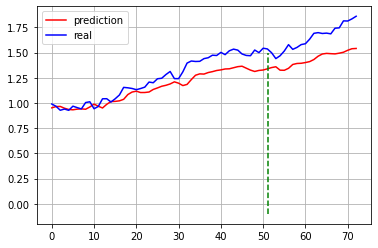

test rmse: 2.04278
test mae: 15.00901
test rmse: 0.00000
test mae: 305.43332


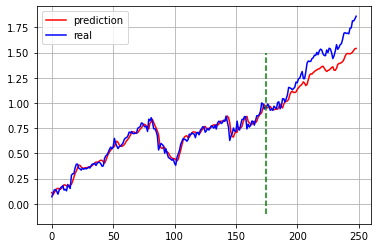

In [30]:
my_test(trained_model, test_dataset, train_scaler, f'result_img/{comp}_test_result{"_sent" if with_sent else ""}.png')
my_test(trained_model, ori_dataset, train_scaler, f'result_img/{comp}_result{"_sent" if with_sent else ""}.png')

In [18]:
a = torch.randn(3,3)
print(a)
scaler = MinMaxScaler()
b = scaler.fit_transform(a)
b

tensor([[ 1.5041, -0.6789, -0.9794],
        [ 0.5860,  0.1168,  0.5784],
        [ 0.7778,  0.7622, -1.2324]])


array([[1.        , 0.        , 0.13967219],
       [0.        , 0.55213418, 1.        ],
       [0.20898686, 1.        , 0.        ]])

In [20]:
print(scaler.min_)
scaler.scale_

[-0.63822761  0.47110423  0.68056041]


array([1.08919126, 0.69393248, 0.5522375 ])

aapl


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00360
Epoch: 200, Loss:0.00307
Epoch: 300, Loss:0.00287
Epoch: 400, Loss:0.00263
Epoch: 500, Loss:0.00237
Epoch: 600, Loss:0.00212
Epoch: 700, Loss:0.00188
test rmse: 1.74897
test mae: 9.06092


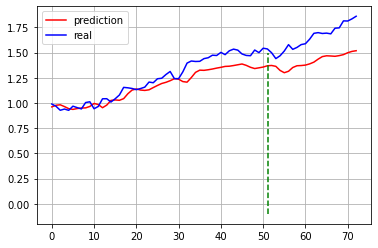

test rmse: 2.06556
test mae: 14.78038


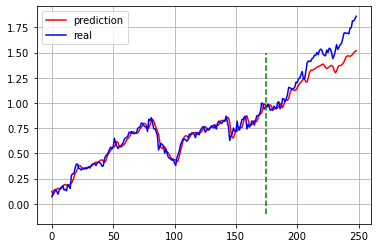

amzn


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00308
Epoch: 200, Loss:0.00204
Epoch: 300, Loss:0.00185
Epoch: 400, Loss:0.00173
Epoch: 500, Loss:0.00148
Epoch: 600, Loss:0.00127
Epoch: 700, Loss:0.00109
test rmse: 0.14829
test mae: 2.62863


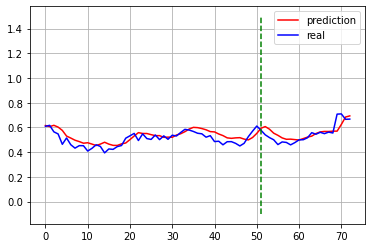

test rmse: 0.66951
test mae: 9.95164


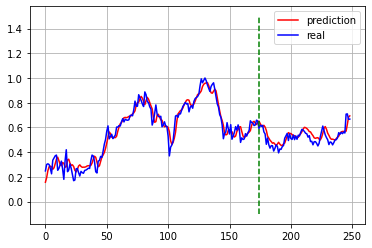

goog


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00323
Epoch: 200, Loss:0.00274
Epoch: 300, Loss:0.00251
Epoch: 400, Loss:0.00220
Epoch: 500, Loss:0.00214
Epoch: 600, Loss:0.00213
Epoch: 700, Loss:0.00208
test rmse: 1.36680
test mae: 8.32727


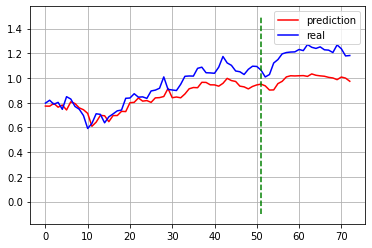

test rmse: 2.13116
test mae: 16.20506


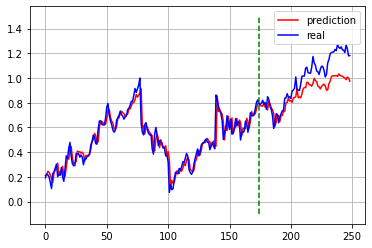

msft


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00140
Epoch: 200, Loss:0.00144
Epoch: 300, Loss:0.00141
Epoch: 400, Loss:0.00135
Epoch: 500, Loss:0.00128
Epoch: 600, Loss:0.00120
Epoch: 700, Loss:0.00117
test rmse: 0.38236
test mae: 4.47962


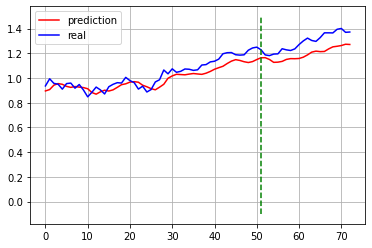

test rmse: 0.64592
test mae: 9.83373


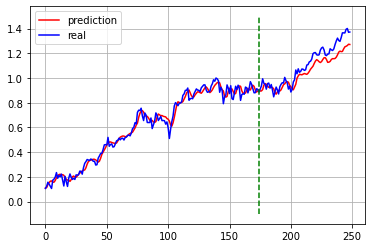

nflx


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00230
Epoch: 200, Loss:0.00151
Epoch: 300, Loss:0.00125
Epoch: 400, Loss:0.00110
Epoch: 500, Loss:0.00099
Epoch: 600, Loss:0.00091
Epoch: 700, Loss:0.00090
test rmse: 0.45901
test mae: 4.63985


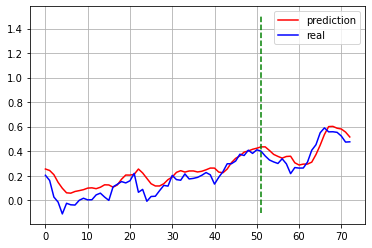

test rmse: 1.19845
test mae: 13.15999


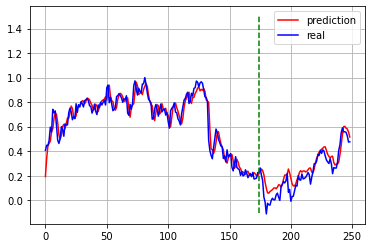

tsla


C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\Liu\anaconda3\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


Epoch: 100, Loss:0.00242
Epoch: 200, Loss:0.00165
Epoch: 300, Loss:0.00132
Epoch: 400, Loss:0.00108
Epoch: 500, Loss:0.00082
Epoch: 600, Loss:0.00067
Epoch: 700, Loss:0.00064
test rmse: 0.84553
test mae: 6.14816


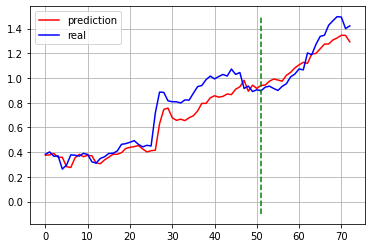

test rmse: 1.23082
test mae: 12.14893


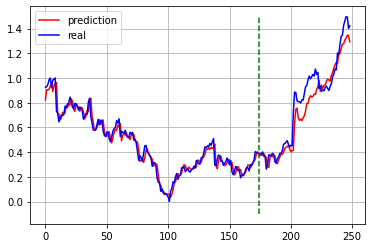

In [76]:
comps = ['aapl', 'amzn', 'goog', 'msft', 'nflx', 'tsla']

for comp in comps:
    print(comp)
    my_eval(comp, with_sent)


## try xgboost to select features

In [15]:
import xgboost as xgb
import numpy as np
import pandas as pd
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

TEST_SIZE = 0.3

def xgb_load_data(csv_file):
    ori_data = pd.read_csv(csv_file)
    
    extend_data = ta.add_all_ta_features(ori_data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
    
    train_data, test_data = train_test_split(ori_data, test_size=TEST_SIZE, shuffle=False)
    return train_data, test_data, ori_data


train_data, test_data, ori_data = xgb_load_data('data/AAPL.csv')

train_data = train_data.iloc[:, 1:]
train_x = train_data.iloc[:-1, 1:]
train_y = train_data.iloc[1:, 4].values

test_data = test_data.iloc[:, 1:]
test_x = test_data.iloc[:-1, 1:]
test_y = test_data.iloc[1:, 4].values

/Users/liu/dsci_560_project/myenv/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/Users/liu/dsci_560_project/myenv/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [20]:
data_dmatrix = xgb.DMatrix(data=train_x.values,label=train_y)
test_dmatrix = xgb.DMatrix(data=test_x.values,label=test_y)

rses = []
# for i in range(10):
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
            'max_depth': 6, 'alpha': 11, 'tree_method': 'hist', 'lambda': 0.1} 
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=50, evals=[(test_dmatrix, 'errors')])
te_preds = xg_reg.predict(test_dmatrix)
rmse = np.sqrt(mean_squared_error(test_y, te_preds))
print('rmse: ', rmse)
#     rses.append((pt, rmse))
#     print(i, rmse)

[20:32:52] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	errors-rmse:113.01026
[1]	errors-rmse:104.49601
[2]	errors-rmse:96.74514
[3]	errors-rmse:89.93866
[4]	errors-rmse:83.43624
[5]	errors-rmse:77.58589
[6]	errors-rmse:72.59512
[7]	errors-rmse:66.93047
[8]	errors-rmse:61.83071
[9]	errors-rmse:57.24035
[10]	errors-rmse:53.82044
[11]	errors-rmse:50.03221
[12]	errors-rmse:47.02351
[13]	errors-rmse:44.61453
[14]	errors-rmse:41.83351
[15]	errors-rmse:39.64758
[16]	errors-rmse:37.89893
[17]	errors-rmse:35.71607
[18]	errors-rmse:34.17898
[19]	errors-rmse:32.62237
[20]	errors-rmse:31.00129
[21]	errors-rmse:29.75846
[22]	errors-rmse:28.84347
[23]	errors-rmse:27.81024
[24]	errors-rmse:27.08557
[25]	errors-rmse:26.03073
[26]	errors-rmse:25.52164
[27]	errors-rmse:24.98928
[28]	errors-rmse:24.14652
[29]	errors-rmse:24.00672
[30]	errors-rmse:23.32227
[31]	errors-rmse:22.83166
[32]	errors-rmse:22.27708
[

In [26]:
importances = xg_reg.get_score(importance_type='gain')
res = sorted(importances.items(), key=lambda x: -x[1])
res

[('f56', 11905.57040405),
 ('f25', 11737.658460617075),
 ('f0', 8419.552833158667),
 ('f41', 4560.65625),
 ('f3', 3942.2264994197094),
 ('f18', 3173.453125),
 ('f1', 2523.9542467499996),
 ('f31', 1680.225341797),
 ('f32', 1677.2402850985),
 ('f24', 1247.86335563),
 ('f14', 1213.2620371102),
 ('f16', 767.6363924000001),
 ('f13', 728.6583794213999),
 ('f23', 661.4594890025716),
 ('f2', 556.6516581407724),
 ('f66', 307.598145),
 ('f5', 243.39853353891664),
 ('f87', 205.029135086),
 ('f42', 180.27246095),
 ('f57', 76.9911499),
 ('f17', 64.1914062),
 ('f59', 39.22134396166667),
 ('f35', 30.613647484999998),
 ('f65', 24.076538096666667),
 ('f27', 14.2793665),
 ('f51', 12.856872535),
 ('f44', 11.252526250499999),
 ('f30', 9.0066628385),
 ('f43', 6.817631416299999),
 ('f50', 6.76679612),
 ('f8', 6.74428557735),
 ('f78', 6.68048096),
 ('f7', 6.196217864666667),
 ('f69', 5.377791885375),
 ('f46', 5.205932623333333),
 ('f63', 5.142871976),
 ('f74', 4.659321122000001),
 ('f19', 4.3507461549999995)

In [30]:
features = [int(item[0][1:])+1 for item in res[:25]]
print(features)

[57, 26, 1, 42, 4, 19, 2, 32, 33, 25, 15, 17, 14, 24, 3, 67, 6, 88, 43, 58, 18, 60, 36, 66, 28]
